In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [150]:
walmart_df = pd.read_csv('walmart_cleaned.csv')

# 데이터를 확인해보자.
walmart_df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [151]:
walmart_df.info()
# date가 시계열적인 특징을 가진 컬럼임을 확인할 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    421570 non-null  int64  
 1   Store         421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   IsHoliday     421570 non-null  int64  
 4   Dept          421570 non-null  float64
 5   Weekly_Sales  421570 non-null  float64
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Type          421570 non-null  int64  
 16  Size          421570 non-null  int64  
dtypes: float64(11), int64(5), object(1)
memory usage

In [152]:
# date 컬럼을 datetime 형식으로 변환한다.
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'])

In [153]:
# 변환이 잘 되었다.
walmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    421570 non-null  int64         
 1   Store         421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   IsHoliday     421570 non-null  int64         
 4   Dept          421570 non-null  float64       
 5   Weekly_Sales  421570 non-null  float64       
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  Type          421

In [154]:
# 시계열을 정리한다.
walmart_df = walmart_df.sort_values(by='Date')

In [155]:
# 연도 컬럼을 생성한다.
walmart_df['Year'] = walmart_df['Date'].dt.year

In [156]:
## 집계 컬럼 함수 설정

def func(walmart_df):
    walmart_df_sum = {}
    # 주간 매출 합계 계산
    walmart_df_sum['Weekly_Sales'] = walmart_df['Weekly_Sales'].sum()
    # 평균 온도 계산
    walmart_df_sum['Temperature'] = walmart_df['Temperature'].mean()
    # 평균 연료 가격 계산
    walmart_df_sum['Fuel_Price'] = walmart_df['Fuel_Price'].mean()
    # 평균 소비자 물가 지수(CPI) 계산
    walmart_df_sum['CPI'] = walmart_df['CPI'].mean()
    # 평균 실업률 계산
    walmart_df_sum['Unemployment'] = walmart_df['Unemployment'].mean()
    # 공휴일 여부 계산 (최대값, 공휴일이 하나라도 포함되어 있으면 1로 설정)
    walmart_df_sum['IsHoliday'] = walmart_df['IsHoliday'].max()
    return pd.Series(walmart_df_sum, index=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday'])

In [157]:
walmart_df_agg = walmart_df.groupby(['Year', 'Date']).apply(func).reset_index()

In [158]:
walmart_df_agg

,Year,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,2010,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,0.0
1,2010,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,1.0
2,2010,2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,0.0
3,2010,2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,0.0
4,2010,2010-03-05,46871470.30,42.373998,2.731816,167.727351,8.572689,0.0
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,175.919639,7.225855,0.0
139,2012,2012-10-05,47566639.31,65.456811,3.848435,175.998254,6.942141,0.0
140,2012,2012-10-12,46128514.25,57.687284,3.897425,176.123786,6.952682,0.0
141,2012,2012-10-19,45122410.57,60.152756,3.878413,176.295499,6.948928,0.0


### 매출 트렌드

Text(0.5, 1.0, '2010 ~ 2012 매출 트렌드')

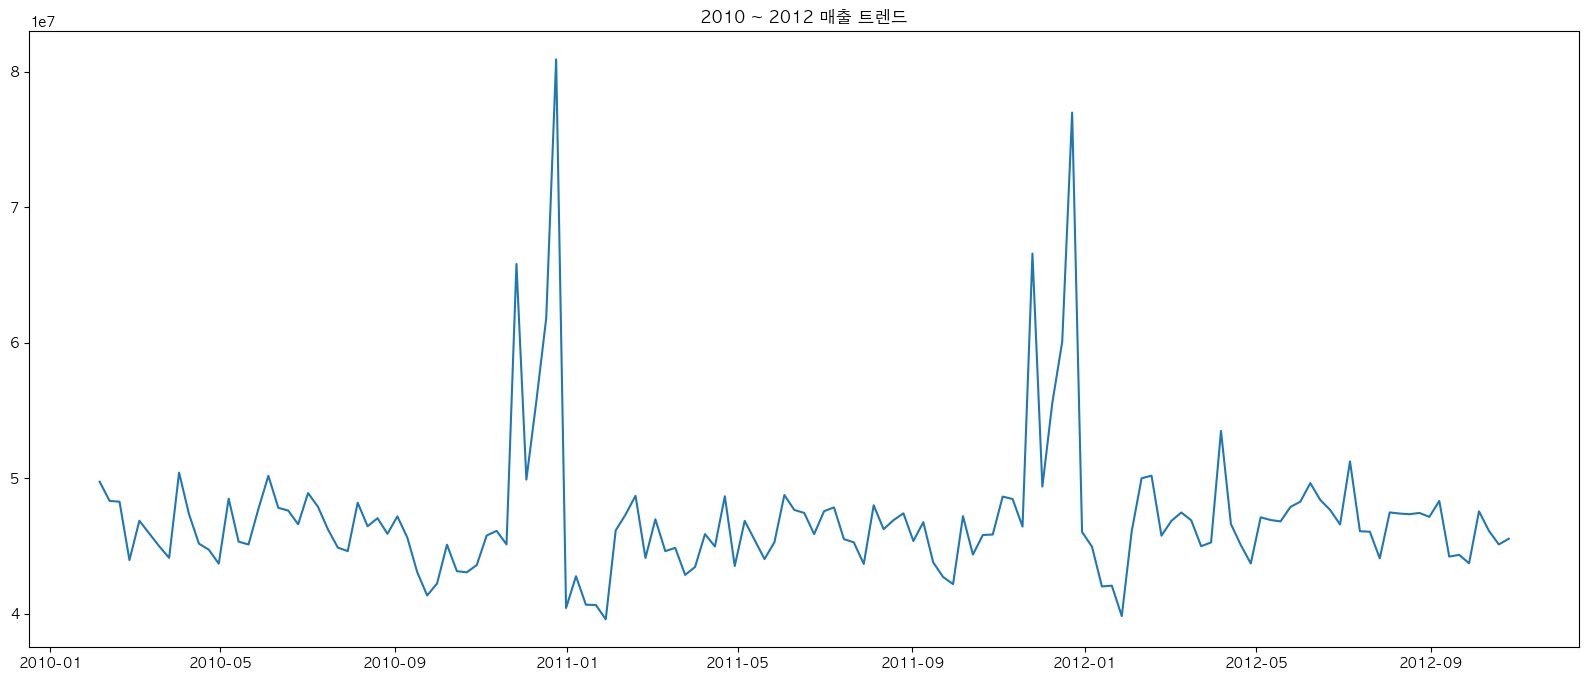

In [159]:
plt.rcParams['font.family'] = 'AppleGothic'

# 연도별 매출 트렌드
plt.figure(figsize=(20, 8))
plt.plot(walmart_df_agg.Date, walmart_df_agg.Weekly_Sales)
plt.title("2010 ~ 2012 매출 트렌드")

- 2011년 1월과 2012년 1월을 중심으로 급격한 등락폭을 보여준다.
- 이벤트나 계절성이 존재하는 것 같다.

In [160]:
# 시계열 분해
ts_decomp_Weekly_Sales = walmart_df_agg.loc[:, ['Date', 'Weekly_Sales']]
ts_decomp_Weekly_Sales.index = ts_decomp_Weekly_Sales.Date
ts_decomp_Weekly_Sales = ts_decomp_Weekly_Sales.drop('Date', axis=1)

In [161]:
# 월, 주, 일로 나눠주자.
decomp_Weekly_Sales = seasonal_decompose(ts_decomp_Weekly_Sales['Weekly_Sales'], model='additive', period=7) # 1주기로

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


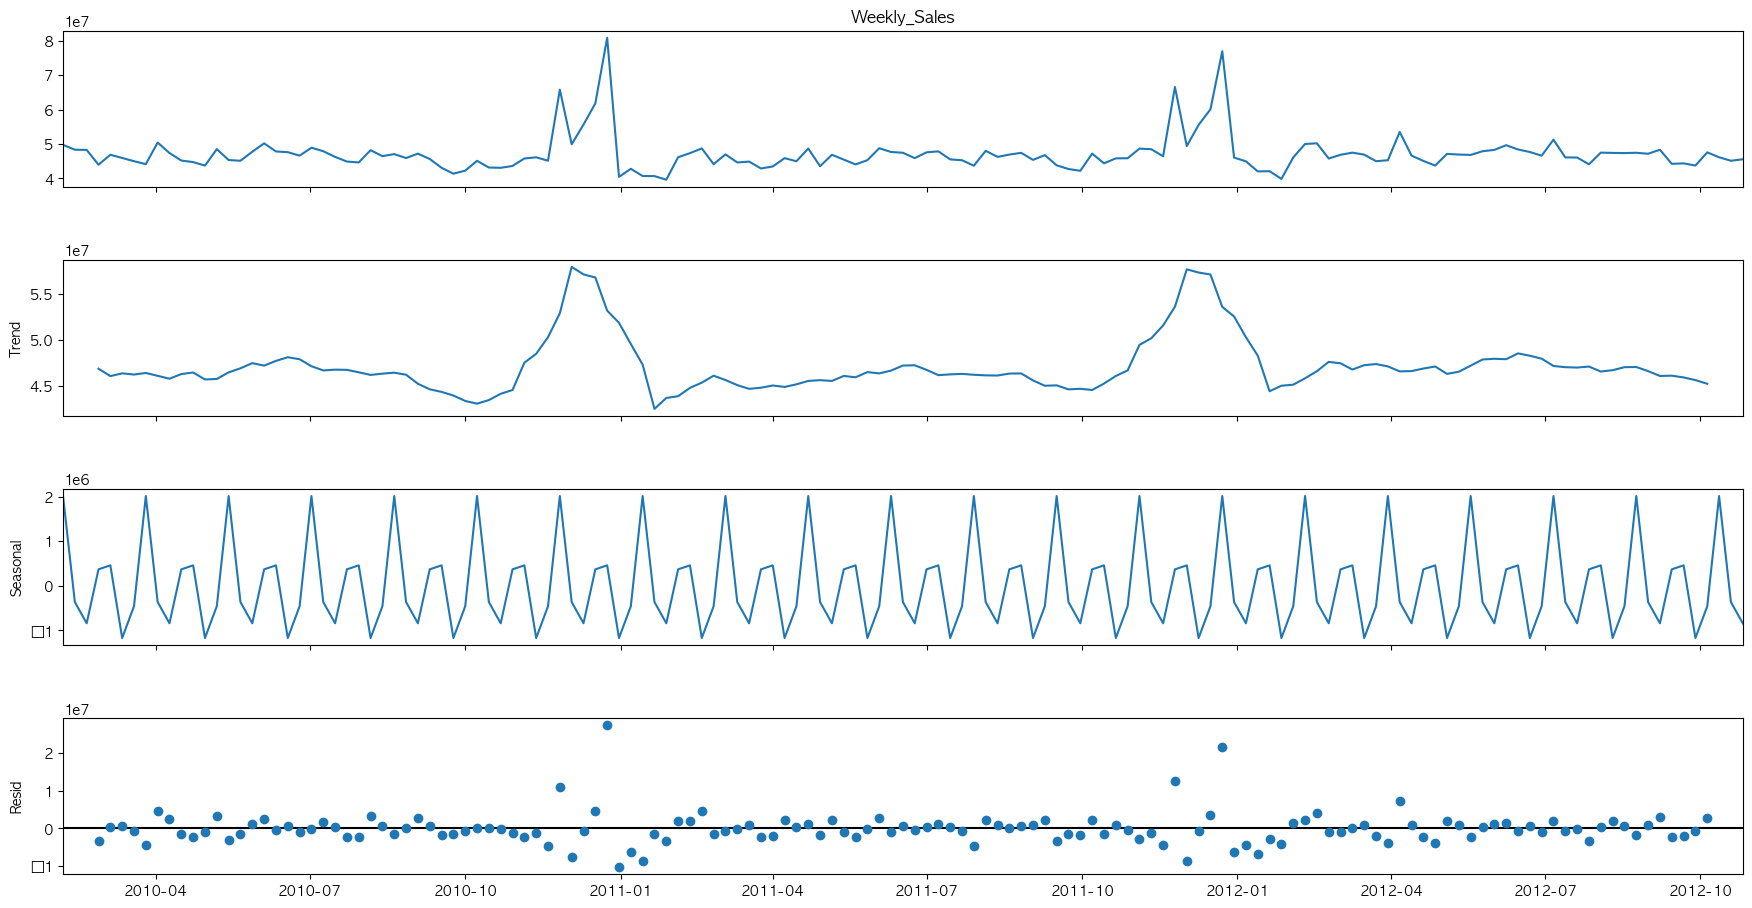

In [162]:
plt.rcParams['font.family'] = 'AppleGothic'

fig_Weekly_Sales = plt.figure()
fig_Weekly_Sales = decomp_Weekly_Sales.plot()
fig_Weekly_Sales.set_size_inches(20, 10)

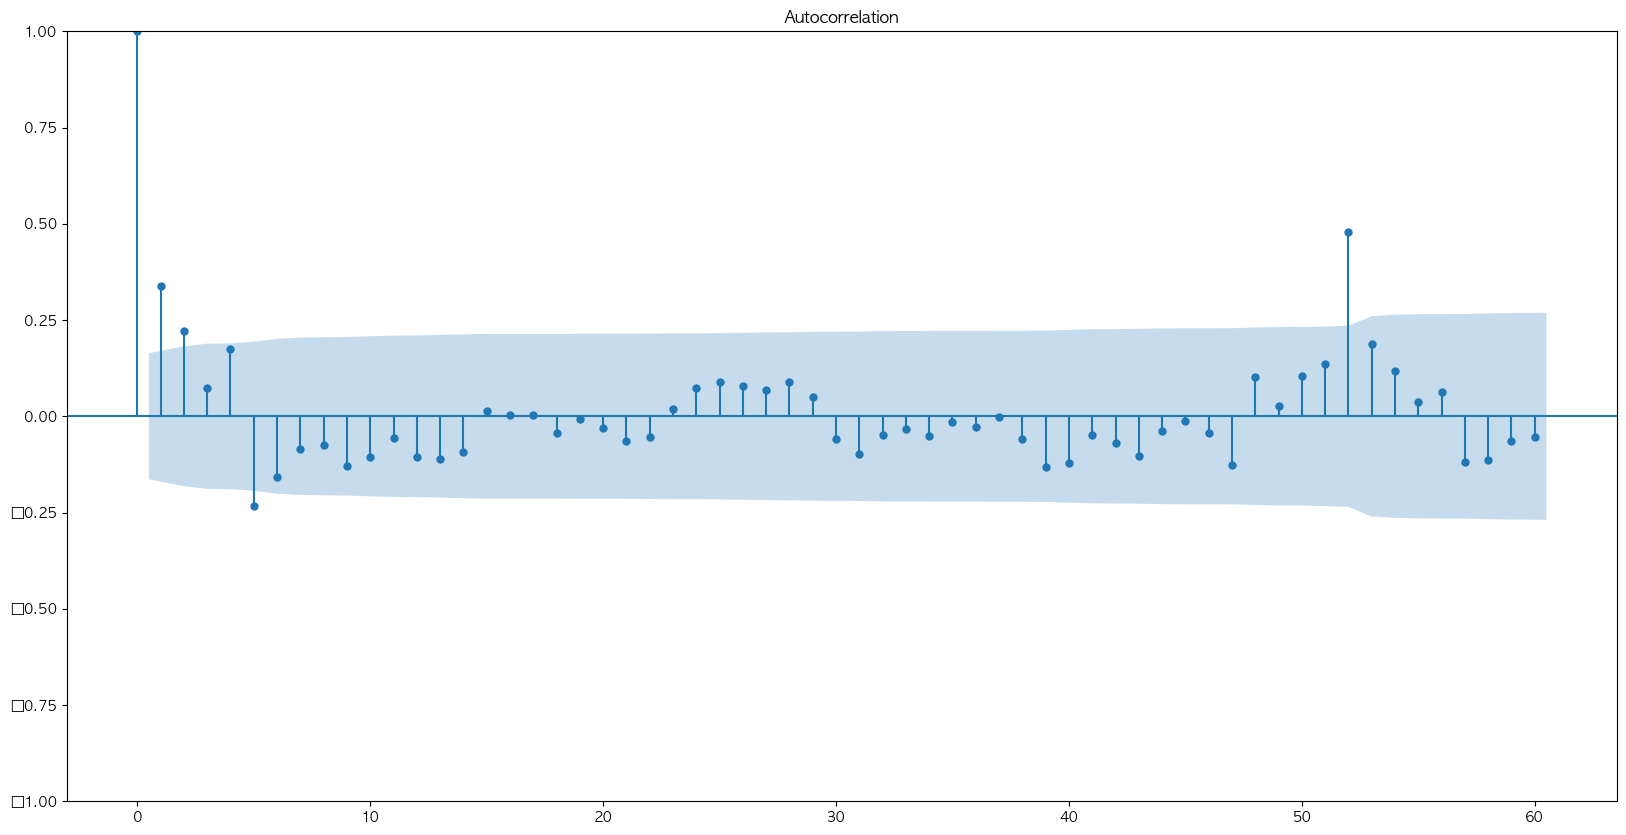

In [163]:
## ACF 그래프
fig_Weekly_Sales = plt.figure(figsize=(20, 10))
ax1_Weekly_Sales = fig_Weekly_Sales.add_subplot(111)
fig_Weekly_Sales = sm.graphics.tsa.plot_acf(ts_decomp_Weekly_Sales, lags=60, ax = ax1_Weekly_Sales)

/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/kimjukyeong/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


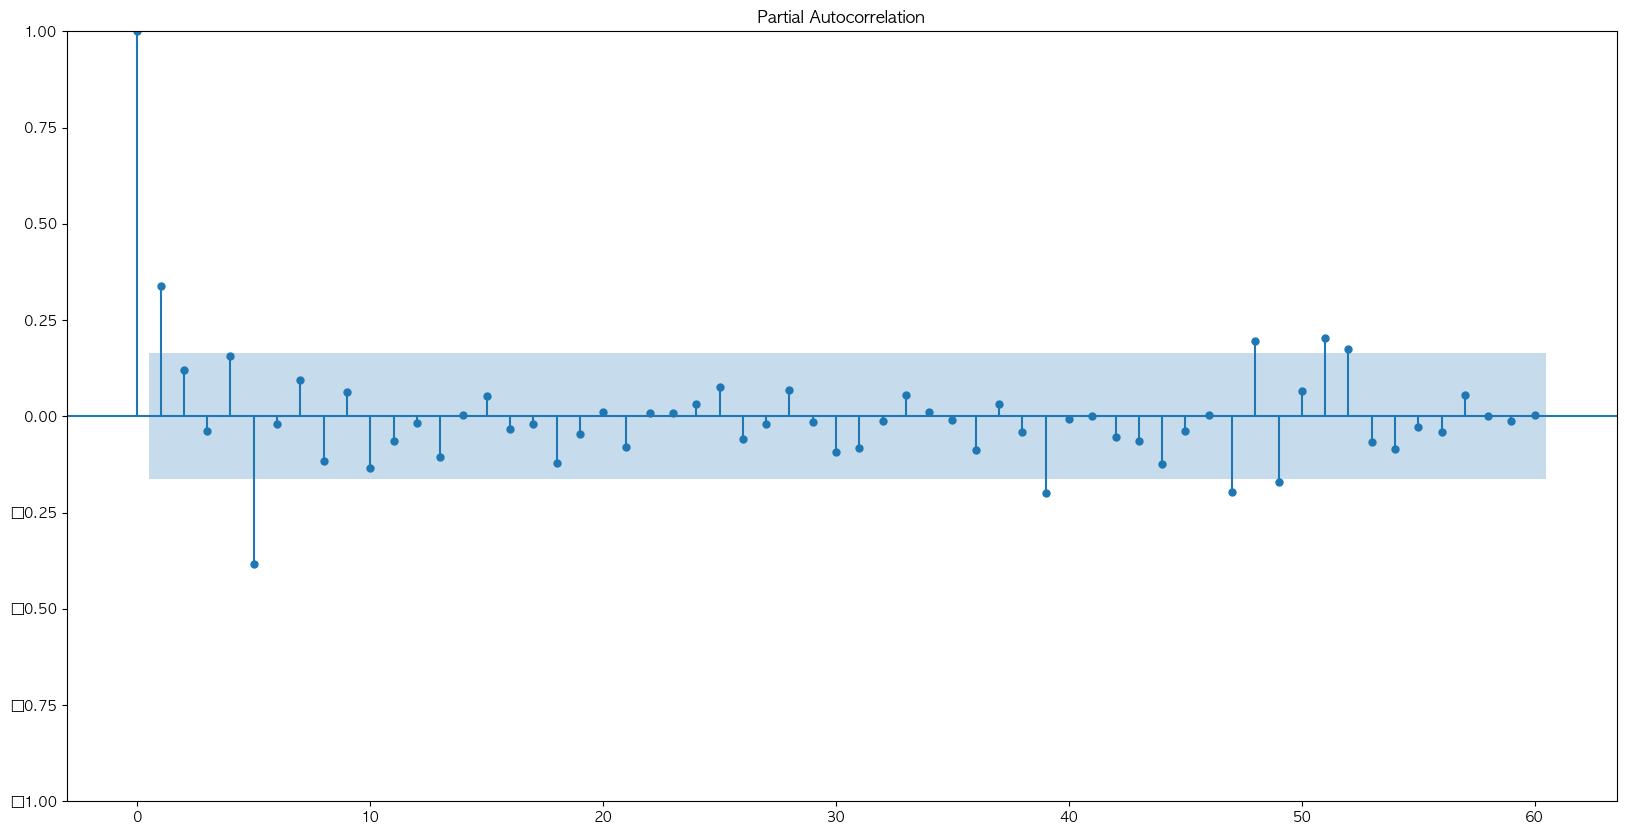

In [164]:
## PACF 그래프
fig_Weekly_Sales = plt.figure(figsize=(20, 10))
ax1_Weekly_Sales = fig_Weekly_Sales.add_subplot(111)
fig_Weekly_Sales = sm.graphics.tsa.plot_pacf(ts_decomp_Weekly_Sales, lags=60, ax = ax1_Weekly_Sales)

## 1. 선형회귀로 예측

In [165]:
## shift() 함수는 데이터를 지정된 기간만큼 이동시킨다.
 # 예를 들어, shift(1)은 데이터를 1행 아래로 이동시키며, 위쪽에 빈 값(NaN)을 채운다.

## 데이터셋은 1 ~ 4주 전 매출액
walmart_df_agg['Weekly_Sales_1w'] = walmart_df_agg['Weekly_Sales'].shift(1)
walmart_df_agg['Weekly_Sales_2w'] = walmart_df_agg['Weekly_Sales'].shift(2)
walmart_df_agg['Weekly_Sales_3w'] = walmart_df_agg['Weekly_Sales'].shift(3)
walmart_df_agg['Weekly_Sales_4w'] = walmart_df_agg['Weekly_Sales'].shift(4)
walmart_df_agg['Weekly_Sales_52w'] = walmart_df_agg['Weekly_Sales'].shift(52)


In [166]:
walmart_df_agg

,Year,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales_1w,Weekly_Sales_2w,Weekly_Sales_3w,Weekly_Sales_4w,Weekly_Sales_52w
0,2010,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,0.0,NaN,NaN,NaN,NaN,NaN
1,2010,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,1.0,49750740.50,NaN,NaN,NaN,NaN
2,2010,2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,0.0,48336677.63,49750740.50,NaN,NaN,NaN
3,2010,2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,0.0,48276993.78,48336677.63,49750740.50,NaN,NaN
4,2010,2010-03-05,46871470.30,42.373998,2.731816,167.727351,8.572689,0.0,43968571.13,48276993.78,48336677.63,49750740.50,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,175.919639,7.225855,0.0,44354547.11,44226038.65,48330059.31,47159639.43,42195830.81
139,2012,2012-10-05,47566639.31,65.456811,3.848435,175.998254,6.942141,0.0,43734899.40,44354547.11,44226038.65,48330059.31,47211688.36
140,2012,2012-10-12,46128514.25,57.687284,3.897425,176.123786,6.952682,0.0,47566639.31,43734899.40,44354547.11,44226038.65,44374820.30
141,2012,2012-10-19,45122410.57,60.152756,3.878413,176.295499,6.948928,0.0,46128514.25,47566639.31,43734899.40,44354547.11,45818953.44


In [167]:
## 모델의 학습을 위해 기간을 설정
walmart_df_agg_set = walmart_df_agg[walmart_df_agg['Date'].isin(pd.date_range('2010-02-05', '2012-10-26'))]

In [168]:
# NaN 값을 포함하는 행 삭제
walmart_df_agg_set = walmart_df_agg_set.dropna()

In [169]:
walmart_df_agg.columns

Index(['Year', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'Weekly_Sales_1w', 'Weekly_Sales_2w',
       'Weekly_Sales_3w', 'Weekly_Sales_4w', 'Weekly_Sales_52w'],
      dtype='object')

In [170]:
## 독립변수와 종속변수를 분리한다.
df_x = walmart_df_agg_set.drop(['Year', 'Date', 'Weekly_Sales'], axis=1)
df_y = walmart_df_agg_set['Weekly_Sales']

In [171]:
df_x

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales_1w,Weekly_Sales_2w,Weekly_Sales_3w,Weekly_Sales_4w,Weekly_Sales_52w
52,29.807584,3.136416,168.894550,8.237056,0.0,39599852.99,40654648.03,40673678.04,42775787.77,49750740.50
53,31.445705,3.163657,169.106782,8.233422,1.0,46153111.12,39599852.99,40654648.03,40673678.04,48336677.63
54,45.219606,3.183584,169.234229,8.244219,0.0,47336192.79,46153111.12,39599852.99,40654648.03,48276993.78
55,42.344853,3.213339,169.490884,8.243163,0.0,48716164.12,47336192.79,46153111.12,39599852.99,43968571.13
56,43.982755,3.394307,169.618032,8.242732,0.0,44125859.84,48716164.12,47336192.79,46153111.12,46871470.30
...,...,...,...,...,...,...,...,...,...,...
138,68.151759,3.858245,175.919639,7.225855,0.0,44354547.11,44226038.65,48330059.31,47159639.43,42195830.81
139,65.456811,3.848435,175.998254,6.942141,0.0,43734899.40,44354547.11,44226038.65,48330059.31,47211688.36
140,57.687284,3.897425,176.123786,6.952682,0.0,47566639.31,43734899.40,44354547.11,44226038.65,44374820.30
141,60.152756,3.878413,176.295499,6.948928,0.0,46128514.25,47566639.31,43734899.40,44354547.11,45818953.44


In [172]:
df_y

52     46153111.12
53     47336192.79
54     48716164.12
55     44125859.84
56     46980603.74
          ...     
138    43734899.40
139    47566639.31
140    46128514.25
141    45122410.57
142    45544116.29
Name: Weekly_Sales, Length: 91, dtype: float64

In [173]:
## train, test 데이터셋을 나눈다.
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=111)
# 학습 데이터 셋 (X_train, y_train) : 모델을 학습시키는데 사용, 모데일 이 데이터를 통해 패턴을 학습
# 테스트 데이터 셋 (X_test, y_test) : 학습된 모델을 평가하는데 사용, 학습된 모델이 새로운 데이터에 대해 얼마나 잘 예측하는지를 평가
# 'test_size = 0.2' : 테스트 데이터셋의 비율을 0.2로 설정 (80% 학습, 20% 테스트)
# 'random_state = 111' : 난수 시드를 111로 설정 (난수 시드를 설정하면 항상 동일한 결과를 얻을 수 있음)

#### 모델 학습하기

In [174]:
# LinearRegression은 Scikit-Learn 라이브러리에서 제공하는 선형 회귀 모델
# fit_intercept=True는 모델이 절편(intercept)을 학습하도록 설정
 # 회귀 모델의 식은 𝑦 = 𝛽_0 + (𝛽_1 * 𝑥_1) + (𝛽_2 * 𝑥_2) + ⋯ + (𝛽_n * 𝑥_n)
  # fit_intercept = True일 경우, 모델이 데이터를 중심으로 회귀선을 적절히 위치시키기 위해 절편을 학습
  # fit_intercept = False일 경우, 절편을 학습하지 않음(절편을 0으로 고정), y = (𝛽_1 * 𝑥_1) + (𝛽_2 * 𝑥_2) + ⋯ + (𝛽_n * 𝑥_n) 형태의 회귀선을 학습
lr = LinearRegression(fit_intercept = True)

In [175]:
# fit 메서드는 학습 데이터를 사용하여 모델을 학습시키는 메서드
lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)

In [176]:
len(y_predict)

19

In [177]:
len(y_test)

19

In [178]:
## 결정계수 값을 출력한다.
## 결정계수값은 모델이 데이터를 얼마나 잘 예측하는지를 나타내는 지표.
 # 1에 가까울수록 데이터를 잘 예측하는 모델
 # 0에 가까울수록 데이터를 잘 예측하지 못하는 모델
 # 음수일 경우, 모델이 데이터를 엉망으로 예측
print('학습셋 R-square : {:.5f}',format(lr.score(X_train, y_train)))
print('테스트셋 R-square : {:.5f}',format(lr.score(X_test, y_test)))

학습셋 R-square : {:.5f} 0.8081493763103673
테스트셋 R-square : {:.5f} 0.9765366969232295


In [179]:
## ADF 검정 p-value
 # ADF 검정은 시계열 데이터가 정상(stationary)인지 여부를 검사하는 통계적 방법 중 하나
  # 정상성은 시계열 데이터의 평균과 분산이 시간에 따라 일정한 특성을 가지는 것

# p-value 0.05 미만이면 대립가설 채택, 정상성 만족 확인
def ADF(ts_temp): # 시계열 데이터를 입력으로 받는다. # 'res'는 ADF 검정 결과를 저장하는 튜플
    res =adfuller(ts_temp.values, autolag='AIC')
    # ts_temp.values는 입력된 시계열 데이터를 배열로 변환
    # autolag='AIC'는 최적의 지연 길이를 Akaike 정보 기준(AIC)을 사용하여 자동으로 선택
    print('ADF Test')
    print('ADF Statistic: %f' %res[0]) # ADF 통계량을 출력합니다. 이 값이 작을수록 시계열 데이터가 정상성을 가진다는 증거가 강해진다.
    print('P-value: %1.10f' %res[1]) # 일반적으로 p-value가 0.05 미만이면 데이터가 정상성을 가진다고 판단
    print('Lag: %d' %res[2]) # 사용된 지연 길이를 출력
    print('Observation %d' %res[3]) # 관측된 데이터 포인트의 수를 출력
    print('Critical Values:') # 여러 신뢰 수준에서의 임계값을 출력한다.
    # ADF 통계량이 이 임계값보다 작으면 해당 신뢰 수준에서 데이터가 정상성을 가진다고 판단
    for key, value in res[4].items():
        print('\t%s: %.3f' %(key, value))
        


In [181]:
#정상성을 테스트한 것 p-value
ADF(ts_decomp_Weekly_Sales)

ADF Test
ADF Statistic: -5.908298
P-value: 0.0000002676
Lag: 4
Observation 138
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


### ARIMA로 예측하기

In [182]:
ts_decomp_Weekly_Sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [184]:
train = ts_decomp_Weekly_Sales.loc['2010-02-15':'2012-09-28']
test = ts_decomp_Weekly_Sales.loc['2012-10-05':'2012-10-26']

In [185]:
print(len(train))
print(len(test))

137
4


In [186]:
train

,Weekly_Sales
Date,
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
2010-03-12,45925396.51
2010-03-19,44988974.64
...,...
2012-08-31,47159639.43
2012-09-07,48330059.31
2012-09-14,44226038.65


In [187]:
## ARIMA 패키지로 사용
## p, d, q: ARIMA 모델의 파라미터를 설정한다.
 # p: 자기회귀 부분(AR)의 차수. 이전 관측값을 몇 개 사용할지 결정
 # d: 차분(I) 부분의 차수. 데이터의 차분 횟수를 결정하여 정상성을 확보
 # q: 이동 평균 부분(MA)의 차수. 이전 예측 오차를 몇 개 사용할지 결정
p,d,q = 2,0,2
ml_arima=ARIMA(train['Weekly_Sales'], order=(p,d,q))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [188]:
#모델 학습
ml_arima_fit=ml_arima.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [189]:
#ml_arima_fit ARIMA에서 제공하는 메서드 forecast
pred1=ml_arima_fit.forecast(steps=4)

In [190]:
pred1 = pd.Series(pred1, index= test.index)

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

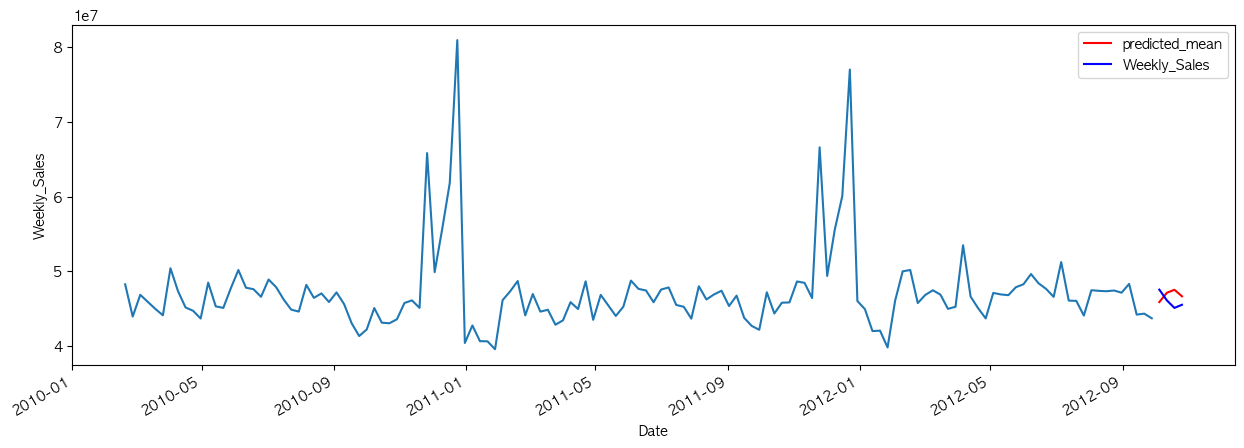

In [191]:
## 실제값과 예측값에 대한 확인
fig,ax = plt.subplots(figsize=(15,5))
grp = sns.lineplot(x='Date', y='Weekly_Sales',data=train)
pred1.plot(ax=ax, color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

- 데이터가 실제 패턴을 잡지 못한 부분
- 휴일, 계절성, 월별 지수 등이 분명 존재

In [192]:
## Auto-Arima(데이터셋, seasonal =True ) #계절성을 어느정도 반영할 수 있다.
auto_arima_ml=pm.auto_arima(train, seasonal=True, m=52)

In [193]:
#패키지 자체에서 predict 예측값 
pred2=auto_arima_ml.predict(4) 
pred2= pd.Series(pred2, index= test.index)

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

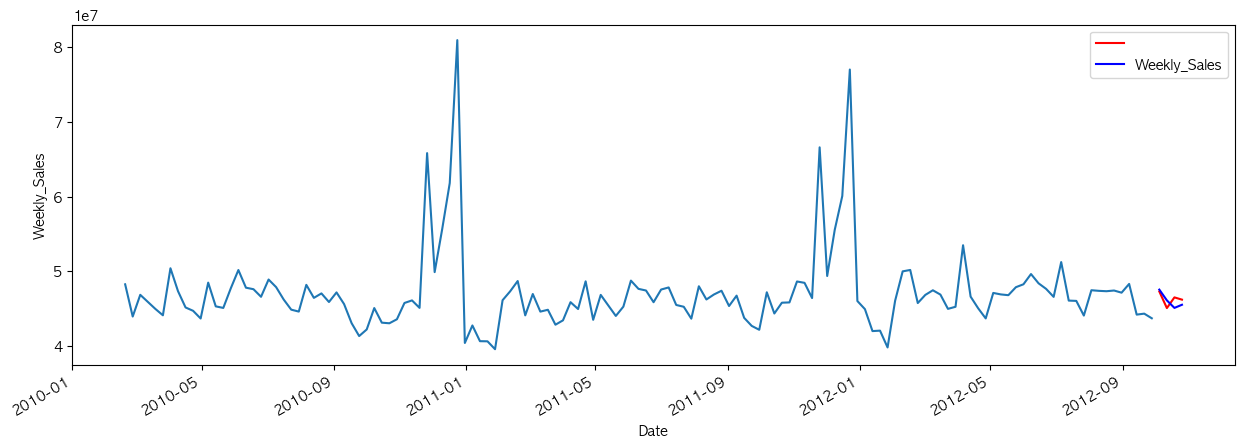

In [194]:
fig,ax = plt.subplots(figsize=(15,5))
grp = sns.lineplot(x='Date', y='Weekly_Sales',data=train)
pred2.plot(ax=ax, color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

In [195]:
#ARIMA 모델등의 요약통계치도 확인할 수 있다.
auto_arima_ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  137
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2280.271
Date:                             Sun, 21 Jul 2024   AIC                           4574.542
Time:                                     16:26:44   BIC                           4594.982
Sample:                                 02-19-2010   HQIC                          4582.848
                                      - 09-28-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.121e+07   1.27e-08   2.46e+15      0.000    3.12e+07    3.12e+07
ar.L1         -0.8175      0.226     -3.614      0.000      -1.261      -0.374
ar.L2         -0.1658      0.352     -0.471      0.638      -0.856       0.524
ma.L1          1.2198      0.243      5.019      0.000       0.743       1.696
ma.L2          0.6297      0.238      2.644      0.008       0.163       1.096
ar.S.L52       0.6676      0.042     15.727      0.000       0.584       0.751
sigma2      2.482e+13   1.62e-14   1.54e+27      0.000    2.48e+13    2.48e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               795.00
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.72e+43. Standard errors may be unstable.
"""